In [3]:
import polars as pl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
import polars as pl

def adjust(df):
    selection_cut = ((pl.col("eta").abs() < 10))

    df_update = df.filter(selection_cut)
    df_update = df_update.with_columns(
        pl.when(pl.col("n_wounded") == 0)
        .then(1)
        .otherwise(pl.col("n_wounded"))
        .alias("n_wounded")
    )

    info = f"Remove # of data {len(df) - len(df_update)} rows, {len(df_update)} rows remain."

    return df_update, info


def go(col_name = "eta",
        islog = False,
        pid = 111,
        ignore_wo = True,
        gevt = 35000,
        ratio_ylim = (0.5, 1.5),
        ranges = (-10, 10),
        bins = 40,
        x_label = "xx",
        y_label = 'yy',
        title = rf"$\pi^0 : pO$",
        save_to = None
        ):


    df_dict = {
        "EPOS-LHC-R" : pl.read_parquet('/home/kywu/work/ss2025/sinica_practice/pq/pO_EPOS-LHC-R_35000.parquet'),
        "DPMJET-III-19.3" : pl.read_parquet('/home/kywu/work/ss2025/sinica_practice/pq/pO_DPMJET-III-19.3_35000.parquet'),
        "QGSJet-III" : pl.read_parquet('/home/kywu/work/ss2025/sinica_practice/pq/pO_QGSJet-III_35000.parquet'),
    }


    fig, (ax_main, ax_ratio) = plt.subplots(
        2, 1, sharex=True, figsize=(7, 6),
        gridspec_kw={"height_ratios":[4,1]}
    )

    # set "EPOS-LHC-R" as the reference model
    ref_model_name : str          = "EPOS-LHC-R"
    ref_model      : pl.DataFrame = df_dict[ref_model_name].filter(pl.col('pid') == pid) if pid else df_dict[ref_model_name].filter(pl.col('charge')!=0)
    ref_model , _                 = adjust(ref_model)
    ref_model_data : np.array     = ref_model[col_name].to_numpy()
    print(f"ref model: {ref_model_name}, data size {len(ref_model_data)}")


    weights = np.ones(len(ref_model_data)) / gevt

    # set up log parameter for histogram
    if islog:
        bin_edges = np.logspace(-5, 1, islog)
        ref_counts, ref_bin_edges = np.histogram(ref_model_data, bins=bin_edges, range=ranges, weights=weights)
        bin_centers = 0.5 * (ref_bin_edges[:-1] + ref_bin_edges[1:]) # 計算 bin 中心位置
        bin_width = np.diff(ref_bin_edges) # 計算 bin 寬度

    else:
        ref_counts, ref_bin_edges = np.histogram(ref_model_data, bins=bins, range=ranges, weights=weights)
        bin_width = ref_bin_edges[1] - ref_bin_edges[0]

    ref_counts_density = ref_counts / bin_width


    for i, (model, df) in enumerate(df_dict.items()):
        df, remove_info = adjust(df)
        df = df.filter(pl.col('pid') == pid) if pid else df.filter(pl.col('charge')!=0)
        print(f' {model=} require {pid=} ') if pid else None
        
        data = df[col_name]

        # set up the weights of current data for histogram plot.
        if ignore_wo:
            weights = np.ones(len(df)) / gevt
        else:
            weights = 1 / (df['n_wounded'] * gevt) if 'n_wounded' in df.columns else np.ones(len(df)) / gevt

        # print(f"{model=} | {df.shape=}", 
        #         f"remove eta -inf, set n_wounded >=0", 
        #         f"{remove_info}" if remove_info else ""
        #         )
        
        # main - histogram
        if islog:
            log_bin_edges = np.logspace(-5, 1, islog)
            current_counts, bin_edges = np.histogram(data, bins=log_bin_edges, range=ranges, weights=weights)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:]) # 計算 bin 中心位置
            bin_width = np.diff(bin_edges) # 計算 bin 寬度
            
        else:
            current_counts, bin_edges = np.histogram(data, bins=bins, range=ranges, weights=weights)
            bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:]) # 計算 bin 中心位置
            bin_width = bin_edges[1] - bin_edges[0] # 計算 bin 寬度

        current_counts_density = current_counts / bin_width

        # main plot
        ax_main.stairs(current_counts_density, bin_edges, 
                        label=model, alpha=0.7, linewidth=1.5)

        # ratio - avoid divide by zero
        ratio = np.divide(current_counts_density, ref_counts_density, 
                            out=np.ones_like(current_counts_density, dtype=float), 
                            where=ref_counts_density!=0)
        
        # subplot - plot
        # ax_ratio.plot(bin_centers, ratio, drawstyle='steps-mid', linewidth=1.2)
        ax_ratio.stairs(ratio, bin_edges, linewidth=1.2)

    # main plot setting
    ax_main.text(0.05, 0.9, title, ha="left", va="center", transform=ax_main.transAxes, fontsize=20)
    ax_main.set_ylabel(y_label, fontsize=20)
    ax_main.set_xscale('log') if islog else None
    ax_main.set_yscale('log') if islog else None
    ax_main.tick_params(axis='x', labelbottom=False)
    ax_main.tick_params(axis='y', labelsize=15)
    ax_main.legend(loc="upper right", fontsize=12, framealpha=0.8)
    ax_main.grid(True, linestyle=":", alpha=0.4)
    ax_main.set_xlim(ranges[0], ranges[1])

    ax_main.margins(y=0.1)

    # subplot setting
    ax_ratio.set_ylabel(f"Model/EPOS", fontsize=15, ha='center')
    ax_ratio.set_xlabel(x_label, fontsize=20)
    ax_ratio.set_xlim(ranges[0], ranges[1])
    ax_ratio.set_ylim(ratio_ylim)
    ax_ratio.set_xscale('log') if islog else None
    ax_ratio.tick_params(labelsize=15)
    ax_ratio.grid(True, linestyle=":", alpha=0.4)
    ax_ratio.axhline(y=1, color='black', linestyle='-', alpha=0.3, linewidth=0.8)

    # share x-axis
    ax_main.sharex(ax_ratio)
    plt.savefig(save_to, dpi=200, bbox_inches='tight', facecolor='white', edgecolor='none') if save_to else None


ref model: EPOS-LHC-R, data size 3726171
ref model: EPOS-LHC-R, data size 1717362
 model='EPOS-LHC-R' require pid=111 
 model='DPMJET-III-19.3' require pid=111 
 model='QGSJet-III' require pid=111 
ref model: EPOS-LHC-R, data size 1533851
 model='EPOS-LHC-R' require pid=211 
 model='DPMJET-III-19.3' require pid=211 
 model='QGSJet-III' require pid=211 
ref model: EPOS-LHC-R, data size 190905
 model='EPOS-LHC-R' require pid=321 
 model='DPMJET-III-19.3' require pid=321 
 model='QGSJet-III' require pid=321 


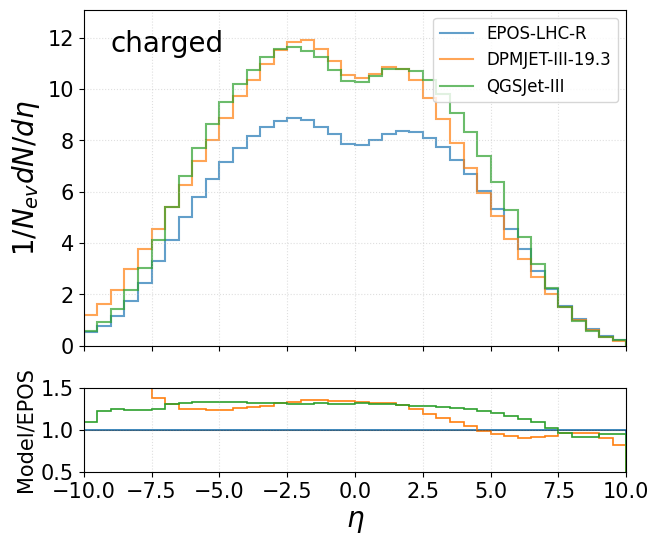

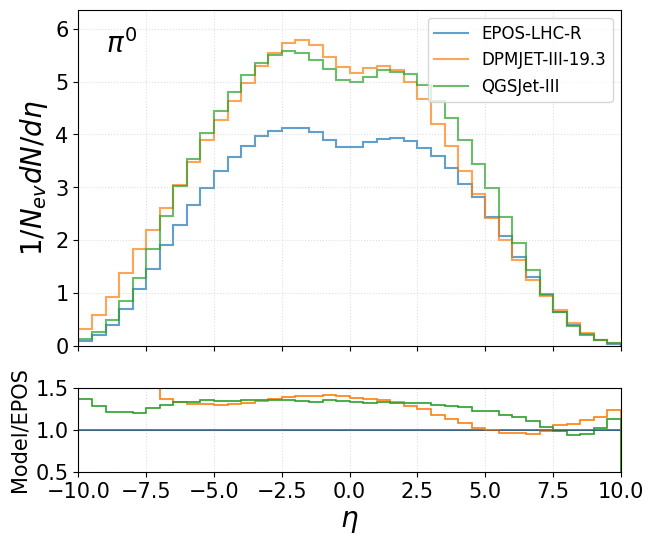

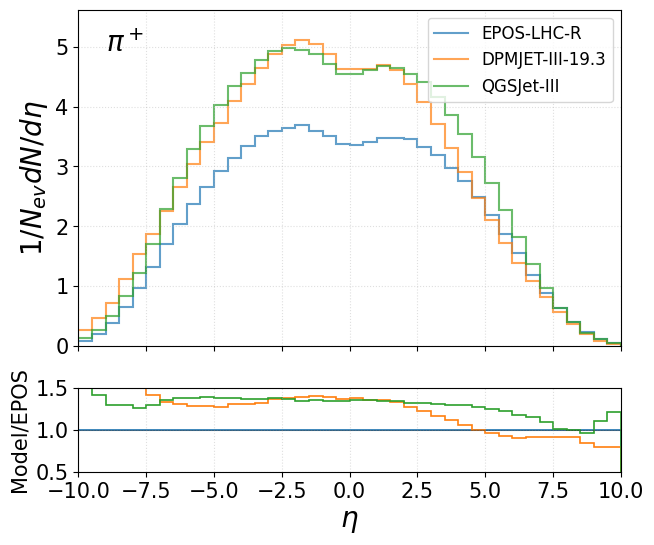

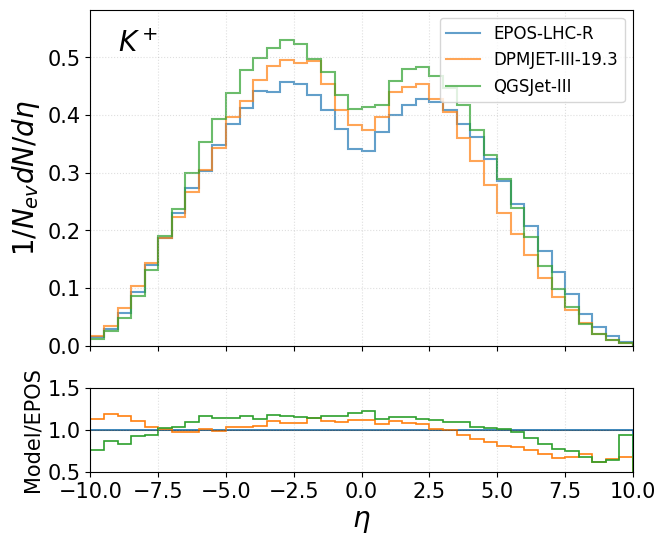

In [8]:
# eta
for pid in [(None, rf"charged"), 
            (111, rf"$\pi^0$"), 
            (211, rf"$\pi^+$"), 
            (321, rf"$K^+$")]:
        go(col_name = "eta", islog = False,
                pid = pid[0],
                ignore_wo = True,
                gevt = 35000,
                ratio_ylim = (0.5, 1.5),
                ranges = (-10, 10),
                bins = 40,
                x_label = r"$\eta$",
                y_label = r"$1/N_{ev}dN/d\eta$",
                title = pid[1],
                )

ref model: EPOS-LHC-R, data size 3726171
ref model: EPOS-LHC-R, data size 1717362
 model='EPOS-LHC-R' require pid=111 
 model='DPMJET-III-19.3' require pid=111 
 model='QGSJet-III' require pid=111 
ref model: EPOS-LHC-R, data size 1533851
 model='EPOS-LHC-R' require pid=211 
 model='DPMJET-III-19.3' require pid=211 
 model='QGSJet-III' require pid=211 
ref model: EPOS-LHC-R, data size 190905
 model='EPOS-LHC-R' require pid=321 
 model='DPMJET-III-19.3' require pid=321 
 model='QGSJet-III' require pid=321 


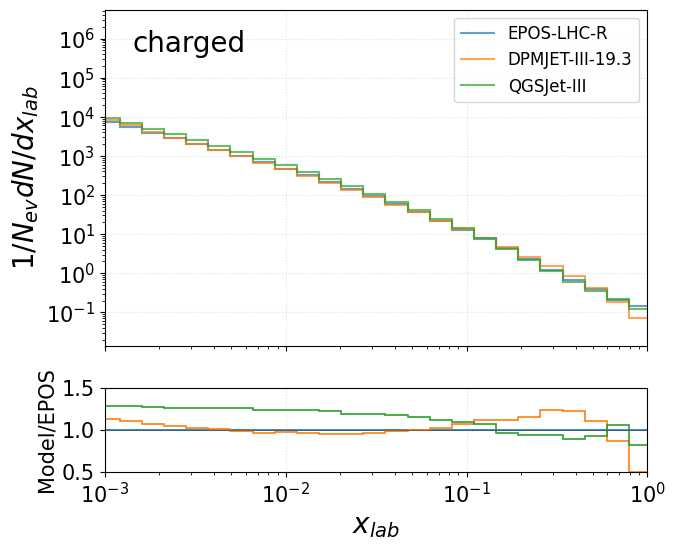

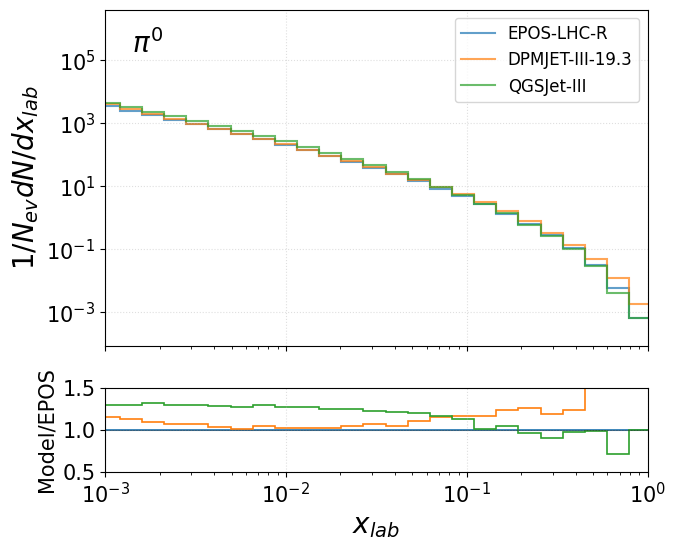

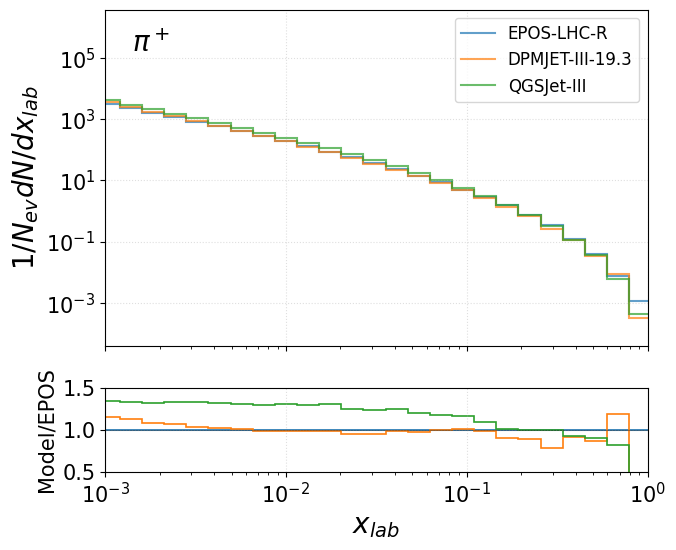

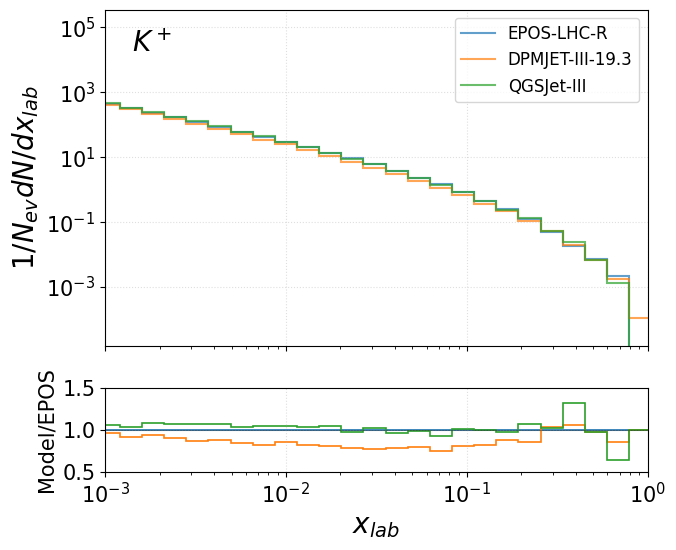

In [7]:
# xlab
for pid in [(None, rf"charged"), 
            (111, rf"$\pi^0$"), 
            (211, rf"$\pi^+$"), 
            (321, rf"$K^+$")]:
    go(col_name = "xlab",
            islog = 50,
            pid = pid[0],
            ignore_wo = True,
            gevt = 35000,
            ratio_ylim = (0.5, 1.5),
            ranges = (0.001, 1),
            bins = 40,
            x_label = r"$x_{lab}$",
            y_label = r"$1/N_{ev}dN/dx_{lab}$",
            title = pid[1],
            )